In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import warnings

warnings.filterwarnings('ignore')

In [116]:
# Load data
df = pd.read_csv('../data/train.csv')
print(f'Data loaded: {df.shape}')

Data loaded: (233154, 41)


# Drop the Columns

In [117]:
# List of columns to drop as per your decision
cols_to_drop = ['UniqueID', 'Sr. NO', 'MobileNo_Avl_Flag', 'Employee_code_ID', 'Current_pincode_ID']

# Dropping them from your main dataframe
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [118]:
def apply_smoothed_encoding(df, target_col, id_cols, m=15):
    """
    Calculates smoothed target encoding for a single dataframe.
    m: The 'smoothing' factor. Higher m makes the score stay closer to the global average.
    """
    global_mean = df[target_col].mean()
    
    # Store mappings in a dictionary for future use on test/new data
    encoding_mappings = {}

    for col in id_cols:
        # Calculate count and mean for each category
        agg = df.groupby(col)[target_col].agg(['count', 'mean'])
        counts = agg['count']
        means = agg['mean']
        
        # Apply smoothing formula
        smooth_val = (counts * means + m * global_mean) / (counts + m)
        
        # Create the new column
        df[f'{col}_risk_score'] = df[col].map(smooth_val)
        
        # Store the mapping
        encoding_mappings[col] = smooth_val.to_dict()
        
        # Drop the original ID column
        df.drop(columns=[col], inplace=True)
        
    return df, encoding_mappings, global_mean

# --- Execution ---
ids_to_encode = ['branch_id', 'supplier_id', 'manufacturer_id', 'State_ID']

# Apply the transformation
df, mappings, overall_avg = apply_smoothed_encoding(df, 'loan_default', ids_to_encode)

print("Data Prepared! ID columns have been replaced with Risk Scores.")

Data Prepared! ID columns have been replaced with Risk Scores.


In [119]:
import numpy as np

# 1. Feature Engineering: Create the derived metrics first
# We create these while the original columns still exist
df['down_payment'] = df['asset_cost'] - df['disbursed_amount']
df['total_monthly_installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']
df['installment_to_loan_ratio'] = df['total_monthly_installment'] / (df['disbursed_amount'] + 1)

# 2. Apply Log Transformation (log1p) to Amount-based columns
# This helps normalize the distribution of currency values
amount_cols_to_log = [
    'disbursed_amount', 
    'asset_cost', 
    'down_payment', 
    'total_monthly_installment'
]

for col in amount_cols_to_log:
    # Creating new log-transformed columns
    df[f'log_{col}'] = np.log1p(df[col])

# 3. Clean up: Drop the original raw columns
# We keep 'ltv' and 'installment_to_loan_ratio' as they are already ratios
# We keep the 'log_' versions and drop the raw currency versions
cols_to_drop = [
    'disbursed_amount', 
    'asset_cost', 
    'PRIMARY.INSTAL.AMT', 
    'SEC.INSTAL.AMT',
    'down_payment',
    'total_monthly_installment'
]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print("Financial Group transformation complete: Log applied and raw columns dropped.")

Financial Group transformation complete: Log applied and raw columns dropped.


In [120]:
import pandas as pd
import re

# 1. Convert Date columns to Datetime objects
# Note: dayfirst=True is used because your examples (31-07-1985) are in DD-MM-YYYY format
df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], dayfirst=True)
df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'], dayfirst=True)

# 2. Calculate Age at the time of Disbursal
# We use 365.25 to account for leap years
df['Age_at_Disbursal'] = (df['DisbursalDate'] - df['Date.of.Birth']).dt.days // 365

# 3. Extract Disbursal Month
# This helps capture end-of-quarter or holiday-season lending patterns
df['Disbursal_Month'] = df['DisbursalDate'].dt.month

# 4. Function to convert "Xyrs Ymon" to total months
def convert_to_months(duration_str):
    if pd.isna(duration_str) or duration_str == "":
        return 0
    # Use regex to find digits for years and months
    years = re.findall(r'(\d+)yrs', duration_str)
    months = re.findall(r'(\d+)mon', duration_str)
    
    total = 0
    if years:
        total += int(years[0]) * 12
    if months:
        total += int(months[0])
    return total

# 5. Apply transformation to History columns
df['Average_Acct_Age_Months'] = df['AVERAGE.ACCT.AGE'].apply(convert_to_months)
df['Credit_History_Length_Months'] = df['CREDIT.HISTORY.LENGTH'].apply(convert_to_months)

# 6. Clean up: Drop original date and string columns
cols_to_drop_dates = [
    'Date.of.Birth', 
    'DisbursalDate', 
    'AVERAGE.ACCT.AGE', 
    'CREDIT.HISTORY.LENGTH'
]

df.drop(columns=cols_to_drop_dates, inplace=True)

print("Date Group transformation complete: Age, Month, and Tenure-months created.")

Date Group transformation complete: Age, Month, and Tenure-months created.


In [121]:
import numpy as np

# 1. Aggregate Primary and Secondary account data
df['Total_No_of_Accounts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']
df['Total_Active_Accounts'] = df['PRI.ACTIVE.ACCTS'] + df['SEC.ACTIVE.ACCTS']
df['Total_Overdue_Accounts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df['Total_Current_Balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']

# 2. Simplify Bureau Score Descriptions
def group_bureau_score(desc):
    if desc in ['A-Very Low Risk', 'B-Very Low Risk', 'C-Very Low Risk', 'D-Very Low Risk']:
        return 'Very_Low_Risk'
    elif desc in ['E-Low Risk', 'F-Low Risk', 'G-Low Risk']:
        return 'Low_Risk'
    elif desc in ['H-Medium Risk', 'I-Medium Risk']:
        return 'Medium_Risk'
    elif desc in ['J-High Risk', 'K-High Risk']:
        return 'High_Risk'
    elif desc in ['L-Very High Risk', 'M-Very High Risk']:
        return 'Very_High_Risk'
    else:
        # This covers all "No History" and "Not Scored" categories
        return 'No_History_or_Not_Scored'

df['Bureau_Score_Category'] = df['PERFORM_CNS.SCORE.DESCRIPTION'].apply(group_bureau_score)
# Mapping the risks to a logical order
risk_order = {
    'No_History_or_Not_Scored': 0,
    'Very_Low_Risk': 1,
    'Low_Risk': 2,
    'Medium_Risk': 3,
    'High_Risk': 4,
    'Very_High_Risk': 5
}

df['Bureau_Score_Category_Encoded'] = df['Bureau_Score_Category'].map(risk_order)
df.drop(columns=['Bureau_Score_Category'], inplace=True)

# 3. Clean up: Drop redundant raw columns
cols_to_drop_bureau = [
    'PRI.NO.OF.ACCTS', 'SEC.NO.OF.ACCTS',
    'PRI.ACTIVE.ACCTS', 'SEC.ACTIVE.ACCTS',
    'PRI.OVERDUE.ACCTS', 'SEC.OVERDUE.ACCTS',
    'PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE',
    'PRI.SANCTIONED.AMOUNT', 'SEC.SANCTIONED.AMOUNT',
    'PRI.DISBURSED.AMOUNT', 'SEC.DISBURSED.AMOUNT',
    'PERFORM_CNS.SCORE.DESCRIPTION'
]

df.drop(columns=cols_to_drop_bureau, inplace=True, errors='ignore')

# 4. Apply Log Transformation to Balance (Optional but recommended)
df['log_Total_Current_Balance'] = np.log1p(df['Total_Current_Balance'])
df['log_Total_Current_Balance'] = df['log_Total_Current_Balance'].replace([np.inf, -np.inf], np.nan)
df['log_Total_Current_Balance'] = df['log_Total_Current_Balance'].fillna(0)
df.drop(columns=['Total_Current_Balance'], inplace=True)

print("Bureau & History Group transformation complete.")

Bureau & History Group transformation complete.


In [122]:
# 1. Employment Type: Fill missing and Encode
# We replace NaN with 'Unknown' to capture the risk of non-disclosure
df['Employment.Type'] = df['Employment.Type'].fillna('Unknown')

# Map categories to numbers
# 0: Salaried, 1: Self Employed, 2: Unknown
emp_map = {'Salaried': 0, 'Self Employed': 1}
# map() will put NaN for anything not in the dictionary, then we fill those NaNs with 2 (Unknown)
df['Employment_Type_Encoded'] = df['Employment.Type'].map(emp_map).fillna(2).astype(int)
df.drop(columns=['Employment.Type'], inplace=True, errors='ignore')

# 2. KYC Score: Consolidate individual flags
flag_cols = ['Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag']
df['Total_KYC_Documents'] = df[flag_cols].sum(axis=1)

# 3. Clean up: Drop original columns
# We drop the individual flags and the original string column for employment
cols_to_drop_kyc = flag_cols + ['Employment.Type']
df.drop(columns=cols_to_drop_kyc, inplace=True, errors='ignore')

# 4. Behavioral Profile: Ensure these are integers
# (Usually they are, but it is good practice to check)
behavioral_cols = [
    'NEW.ACCTS.IN.LAST.SIX.MONTHS', 
    'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 
    'NO.OF_INQUIRIES'
]
for col in behavioral_cols:
    df[col] = df[col].astype(int)

print("KYC & Profile transformation complete: Data is now 100% numerical.")

KYC & Profile transformation complete: Data is now 100% numerical.


In [123]:
import numpy as np
import pandas as pd

def final_data_audit(df):
    print("--- 1. Missing Values Check ---")
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        print("✅ No missing values found.")
    else:
        print(null_counts[null_counts > 0])

    print("\n--- 2. Infinite Values Check ---")
    # Log transformations can sometimes produce inf if 0 is handled incorrectly
    num_df = df.select_dtypes(include=[np.number])
    inf_counts = np.isinf(num_df).sum()
    if inf_counts.sum() == 0:
        print("✅ No infinite values found.")
    else:
        print(inf_counts[inf_counts > 0])

    print("\n--- 3. Data Type Consistency ---")
    # All columns should be int, float, or bool. No 'object' strings should remain.
    non_numeric = df.select_dtypes(exclude=[np.number, bool]).columns
    if len(non_numeric) == 0:
        print("✅ All columns are numerical.")
    else:
        print(f"⚠️ Warning: Found non-numeric columns: {list(non_numeric)}")
        print("Note: 'Bureau_Score_Category' might need Label Encoding.")

    print("\n--- 4. Constant Column Check ---")
    # Columns with only 1 unique value provide no information to the model.
    constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
    if len(constant_cols) == 0:
        print("✅ No constant columns found.")
    else:
        print(f"🚩 Suggest dropping these constant columns: {constant_cols}")

    print("\n--- 5. Target Imbalance Check ---")
    balance = df['loan_default'].value_counts(normalize=True) * 100
    print(f"Class 0 (No Default): {balance[0]:.2f}%")
    print(f"Class 1 (Default):    {balance[1]:.2f}%")

# Execute Audit
final_data_audit(df)

--- 1. Missing Values Check ---
✅ No missing values found.

--- 2. Infinite Values Check ---
✅ No infinite values found.

--- 3. Data Type Consistency ---
✅ All columns are numerical.

--- 4. Constant Column Check ---
✅ No constant columns found.

--- 5. Target Imbalance Check ---
Class 0 (No Default): 78.29%
Class 1 (Default):    21.71%


# FEATURE SELECTION

In [124]:
# The updated, safe way to get correlations
corr_matrix = df.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns with correlation greater than threshold (e.g., 0.9)
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

In [125]:
# Drop the features 
df = df.drop(columns=to_drop)

## VIF 

In [126]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def reduce_vif(df, threshold=10.0):
    """
    Iteratively drops columns with high VIF scores.
    """
    # 1. Select only numerical data
    X = df.select_dtypes(include=[np.number]).copy()
    
    # 2. Add a constant column for VIF calculation
    X = add_constant(X)
    
    dropped_cols = []
    
    while True:
        # 3. Calculate VIF for each remaining column
        vif = pd.Series(
            [variance_inflation_factor(X.values, i) for i in range(X.shape[1])], 
            index=X.columns
        )
        
        # 4. Ignore the constant column for dropping
        vif_no_const = vif.drop('const')
        max_vif = vif_no_const.max()
        
        if max_vif > threshold:
            max_col = vif_no_const.idxmax()
            print(f"Dropping '{max_col}' with VIF: {max_vif:.2f}")
            X = X.drop(columns=[max_col])
            dropped_cols.append(max_col)
        else:
            break

    print(f'Columns to be dropped: {dropped_cols}')
    # Return the clean dataframe (without the added constant)
    return df.drop(columns=dropped_cols)

# Usage
df = reduce_vif(df, threshold=10.0)


Dropping 'log_disbursed_amount' with VIF: 57.00
Columns to be dropped: ['log_disbursed_amount']


## Hypothesis Testing

Let us find those statistically significant variables which are actually impacting our target variable LOAN_DAFAULT.

In [127]:
df.select_dtypes(include=[np.number]).columns

Index(['ltv', 'PERFORM_CNS.SCORE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES',
       'loan_default', 'branch_id_risk_score', 'supplier_id_risk_score',
       'manufacturer_id_risk_score', 'State_ID_risk_score',
       'installment_to_loan_ratio', 'log_asset_cost',
       'log_total_monthly_installment', 'Age_at_Disbursal', 'Disbursal_Month',
       'Average_Acct_Age_Months', 'Credit_History_Length_Months',
       'Total_No_of_Accounts', 'Total_Active_Accounts',
       'Total_Overdue_Accounts', 'Bureau_Score_Category_Encoded',
       'log_Total_Current_Balance', 'Employment_Type_Encoded',
       'Total_KYC_Documents'],
      dtype='str')

Using ANOVA test we will find which all numerical variables are statistically significant with the categorical target variable.


In [128]:
import scipy.stats as stats
signif_num=[]
for i in df.columns:
    zero=df.loc[df.loan_default==0,i]
    one=df.loc[df.loan_default==1,i]
    teststats,pvalue=stats.ttest_ind(zero,one)
    print('Pvalue for',i,'is',pvalue)
    if pvalue<0.05:
        signif_num.append(i)

Pvalue for ltv is 0.0
Pvalue for PERFORM_CNS.SCORE is 1.8694211192573342e-172
Pvalue for NEW.ACCTS.IN.LAST.SIX.MONTHS is 9.3022937102126e-46
Pvalue for DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS is 3.2892517686894744e-62
Pvalue for NO.OF_INQUIRIES is 7.912566786376242e-99
Pvalue for loan_default is 0.0
Pvalue for branch_id_risk_score is 0.0
Pvalue for supplier_id_risk_score is 0.0
Pvalue for manufacturer_id_risk_score is 7.277307830918763e-103
Pvalue for State_ID_risk_score is 0.0
Pvalue for installment_to_loan_ratio is 1.3495091981371868e-06
Pvalue for log_asset_cost is 1.620992811042973e-14
Pvalue for log_total_monthly_installment is 9.690529531159234e-08
Pvalue for Age_at_Disbursal is 6.638402197077454e-23
Pvalue for Disbursal_Month is 1.7065764157703376e-29
Pvalue for Average_Acct_Age_Months is 5.2610914820957936e-33
Pvalue for Credit_History_Length_Months is 4.650017386498591e-92
Pvalue for Total_No_of_Accounts is 1.3735651659229081e-67
Pvalue for Total_Active_Accounts is 1.9209012379459

In [129]:
train_df = df.copy()

# FEATURE SCALING

In [86]:
train_df=train_df.select_dtypes(include=[np.number]).drop('loan_default',axis=1)

In [98]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
num_scaled=ss.fit_transform(train_df)
train_df_scaled=pd.DataFrame(data=num_scaled,columns=train_df.columns)
train_df_scaled.head()

,ltv,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,branch_id_risk_score,supplier_id_risk_score,manufacturer_id_risk_score,State_ID_risk_score,installment_to_loan_ratio,...,Disbursal_Month,Average_Acct_Age_Months,Credit_History_Length_Months,Total_No_of_Accounts,Total_Active_Accounts,Total_Overdue_Accounts,Bureau_Score_Category_Encoded,log_Total_Current_Balance,Employment_Type_Encoded,Total_KYC_Documents
0,1.292133,-0.855453,-0.399782,-0.253566,-0.292450,-0.499814,1.711423,0.622981,-0.332586,-0.077221,...,-1.354180,-0.590198,-0.568640,-0.472559,-0.538022,-0.290193,-0.675567,-0.786912,-1.175829,-0.301635
1,-0.132372,0.911822,-0.399782,2.347632,-0.292450,-0.499814,1.711423,0.622981,-0.332586,-0.064713,...,-0.156027,0.932337,0.236085,-0.283514,-0.034067,1.481513,1.451028,1.029860,0.850464,-0.301635
2,1.299116,-0.855453,-0.399782,-0.253566,-0.292450,-0.499814,1.711423,0.622981,-0.332586,-0.077221,...,-1.354180,-0.590198,-0.568640,-0.472559,-0.538022,-0.290193,-0.675567,-0.786912,0.850464,-0.301635
3,1.198738,0.045917,-0.399782,-0.253566,1.122986,-0.499814,1.711423,0.622981,-0.332586,-0.077061,...,1.042126,-0.060621,-0.043819,0.094576,-0.538022,-0.290193,2.868758,-0.786912,0.850464,-0.301635
4,1.190882,-0.855453,-0.399782,-0.253566,1.122986,-0.499814,1.711423,0.622981,-0.332586,-0.077221,...,-0.156027,-0.590198,-0.568640,-0.472559,-0.538022,-0.290193,-0.675567,-0.786912,0.850464,-0.301635


In [130]:
y=df['loan_default']

## SMOTE

In [131]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()
newX1,newY1=smote.fit_resample(train_df,y)

In [135]:
type(newY1)

pandas.Series

# Logistic Regression

In [97]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split

In [99]:
X_train, X_test, y_train, y_test = train_test_split(train_df_scaled, y, test_size=0.25, random_state=16)

In [100]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [111]:
# 5. Make Predictions
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1] # Probability of default


# 2. Define your custom threshold
custom_threshold = 0.9  # Be more conservative/sensitive

# 3. Apply the threshold manually
y_pred_custom = (y_prob >= custom_threshold).astype(int)


# 6. Print Performance Metrics
print("\n--- Model Performance Report ---")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print(f"F1-Score:      {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 7. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(f"True Negatives:  {cm[0][0]} | False Positives: {cm[0][1]}")
print(f"False Negatives: {cm[1][0]} | True Positives:  {cm[1][1]}")


--- Model Performance Report ---
ROC-AUC Score: 0.6702
F1-Score:      0.0684

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88     45606
           1       0.52      0.04      0.07     12683

    accuracy                           0.78     58289
   macro avg       0.66      0.51      0.47     58289
weighted avg       0.73      0.78      0.70     58289


Confusion Matrix:
True Negatives:  45186 | False Positives: 420
False Negatives: 12219 | True Positives:  464


# Model Training

In [106]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

# 1. Define Features (X) and Target (y)
# X = df.drop(columns=['loan_default'])
y = df['loan_default']

# 2. Split into Training (80%) and Testing (20%) sets
# random_state ensures you get the same results every time you run it
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Calculate the Imbalance Ratio for XGBoost
# Formula: number of negative samples / number of positive samples
# Based on your audit: 78.29 / 21.71 = 3.6
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# 4. Initialize and Train XGBoost
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=ratio, # This handles the 3:1 imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

print("Model Training Complete!")

Model Training Complete!


In [107]:
# 5. Make Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # Probability of default

# 6. Print Performance Metrics
print("\n--- Model Performance Report ---")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print(f"F1-Score:      {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 7. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(f"True Negatives:  {cm[0][0]} | False Positives: {cm[0][1]}")
print(f"False Negatives: {cm[1][0]} | True Positives:  {cm[1][1]}")


--- Model Performance Report ---
ROC-AUC Score: 0.6799
F1-Score:      0.4281

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73     45606
           1       0.32      0.64      0.43     12683

    accuracy                           0.63     58289
   macro avg       0.59      0.63      0.58     58289
weighted avg       0.74      0.63      0.66     58289


Confusion Matrix:
True Negatives:  28654 | False Positives: 16952
False Negatives: 4613 | True Positives:  8070


# Feature Importance

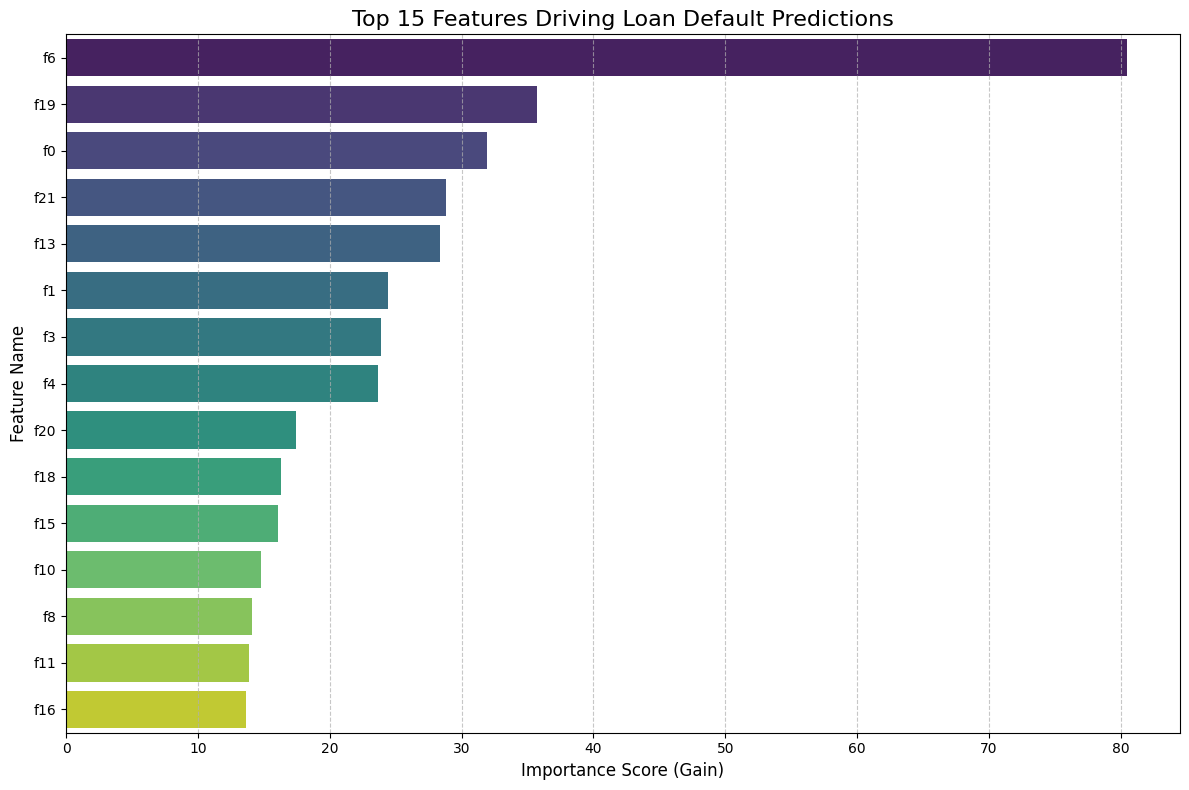

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Extract feature importance from the model
# We use 'Gain' because it represents the improvement in accuracy brought by a feature
importance = model.get_booster().get_score(importance_type='gain')

# 2. Convert to a DataFrame for easy plotting
feat_importances = pd.DataFrame(
    list(importance.items()), 
    columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

# 3. Visualization
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feat_importances.head(15), # Show top 15 features
    palette='viridis'
)

plt.title('Top 15 Features Driving Loan Default Predictions', fontsize=16)
plt.xlabel('Importance Score (Gain)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('feature_importance.png')

# SHAP

In [15]:
# import shap
# import matplotlib.pyplot as plt

# # 1. Initialize the SHAP Explainer
# # TreeExplainer is specifically optimized for XGBoost/Random Forest
# explainer = shap.TreeExplainer(model)
# shap.plots.waterfall(sha
# # # 2. Calculate SHAP values for the test set
# # # This might take a minute depending on the size of your test set
# # shap_values = explainer.shap_values(X_test)

# # # 3. SHAP Summary Plot
# # # This shows the impact of every feature on every single prediction
# # plt.figure(figsize=(10, 8))
# # shap.summary_plot(shap_values, X_test, show=False)
# # plt.title("SHAP Summary Plot: Impact on Default Probability")
# # plt.tight_layout()
# # plt.savefig('shap_summary_plot.png')

# # # 4. SHAP Dependence Plot (Example: LTV)
# # # This shows how the risk changes as a specific variable increases
# # plt.figure(figsize=(8, 6))
# # shap.dependence_plot("ltv", shap_values, X_test, show=False)
# # plt.title("LTV vs. SHAP Value (Risk Contribution)")
# # plt.tight_layout()
# # plt.savefig('shap_ltv_dependence.png')

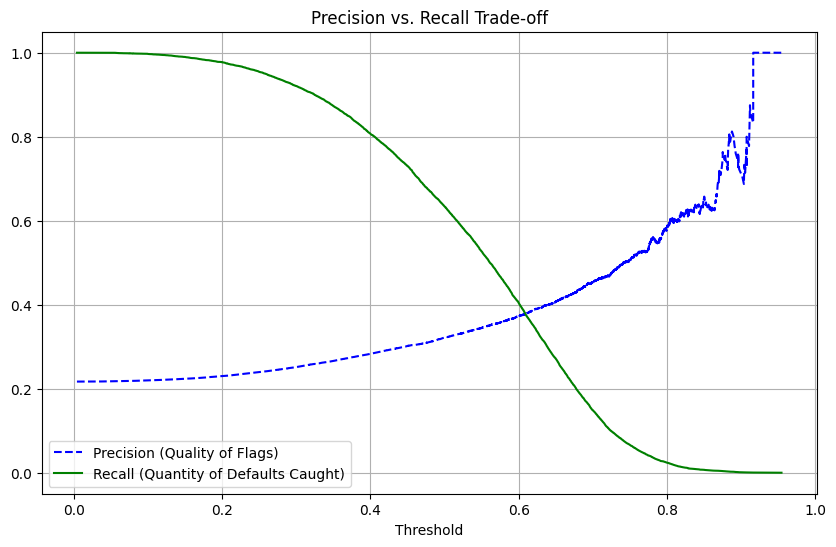

In [16]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# 1. Get the probabilities for the positive class (default)
y_scores = model.predict_proba(X_test)[:, 1]

# 2. Calculate precision and recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# 3. Plot the relationship
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision (Quality of Flags)")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall (Quantity of Defaults Caught)")
plt.xlabel("Threshold")
plt.title("Precision vs. Recall Trade-off")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Set your desired threshold
custom_threshold = 0.4 

# Convert probabilities to binary predictions based on new threshold
y_pred_custom = (y_scores >= custom_threshold).astype(int)

# Check the new Confusion Matrix
print(f"--- Performance at Threshold {custom_threshold} ---")
print(classification_report(y_test, y_pred_custom))

--- Performance at Threshold 0.4 ---
              precision    recall  f1-score   support

           0       0.89      0.43      0.58     36509
           1       0.28      0.81      0.42     10122

    accuracy                           0.51     46631
   macro avg       0.59      0.62      0.50     46631
weighted avg       0.76      0.51      0.55     46631



# HyperParameter Tuning

In [18]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 1. Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.5]
}

# 2. Initialize the base model with your imbalance ratio
xgb = XGBClassifier(
    scale_pos_weight=ratio, # Using the ratio we calculated earlier
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 3. Set up Randomized Search
# n_iter=10 means it will try 10 random combinations
# cv=3 means 3-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10,
    scoring='roc_auc', # We want to maximize AUC!
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1 # Uses all your CPU cores
)

# 4. Run the search
print("Starting Hyperparameter Tuning...")
random_search.fit(X_train, y_train)

# 5. Get the best model
best_model = random_search.best_estimator_

print(f"\nBest Parameters Found: {random_search.best_params_}")
print(f"Best Cross-Validation AUC: {random_search.best_score_:.4f}")

Starting Hyperparameter Tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters Found: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best Cross-Validation AUC: 0.6839


In [19]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report

# 1. Predictions from the Tuned Model
y_pred_tuned = best_model.predict(X_test)
y_prob_tuned = best_model.predict_proba(X_test)[:, 1]

# 2. Store metrics for comparison (assuming you still have y_pred from the first model)
# If you don't have the old metrics saved, we'll just focus on the new ones.
metrics_tuned = {
    'ROC-AUC': roc_auc_score(y_test, y_prob_tuned),
    'Precision': precision_score(y_test, y_pred_tuned),
    'Recall': recall_score(y_test, y_pred_tuned),
    'F1-Score': f1_score(y_test, y_pred_tuned)
}

# 3. Print the results
print("--- Tuned Model Performance ---")
for metric, value in metrics_tuned.items():
    print(f"{metric:10}: {value:.4f}")

print("\nDetailed Classification Report (Tuned):")
print(classification_report(y_test, y_pred_tuned))

# 4. Compare with your Image Results (Baseline)
baseline_auc = 0.6816  # From your uploaded image
improvement = metrics_tuned['ROC-AUC'] - baseline_auc

print(f"\n--- AUC Improvement ---")
print(f"Baseline AUC: {baseline_auc:.4f}")
print(f"Tuned AUC:    {metrics_tuned['ROC-AUC']:.4f}")
print(f"Net Gain:     {improvement:+.4f}")

--- Tuned Model Performance ---
ROC-AUC   : 0.6826
Precision : 0.3173
Recall    : 0.6548
F1-Score  : 0.4274

Detailed Classification Report (Tuned):
              precision    recall  f1-score   support

           0       0.86      0.61      0.71     36509
           1       0.32      0.65      0.43     10122

    accuracy                           0.62     46631
   macro avg       0.59      0.63      0.57     46631
weighted avg       0.75      0.62      0.65     46631


--- AUC Improvement ---
Baseline AUC: 0.6816
Tuned AUC:    0.6826
Net Gain:     +0.0010


# VIF 

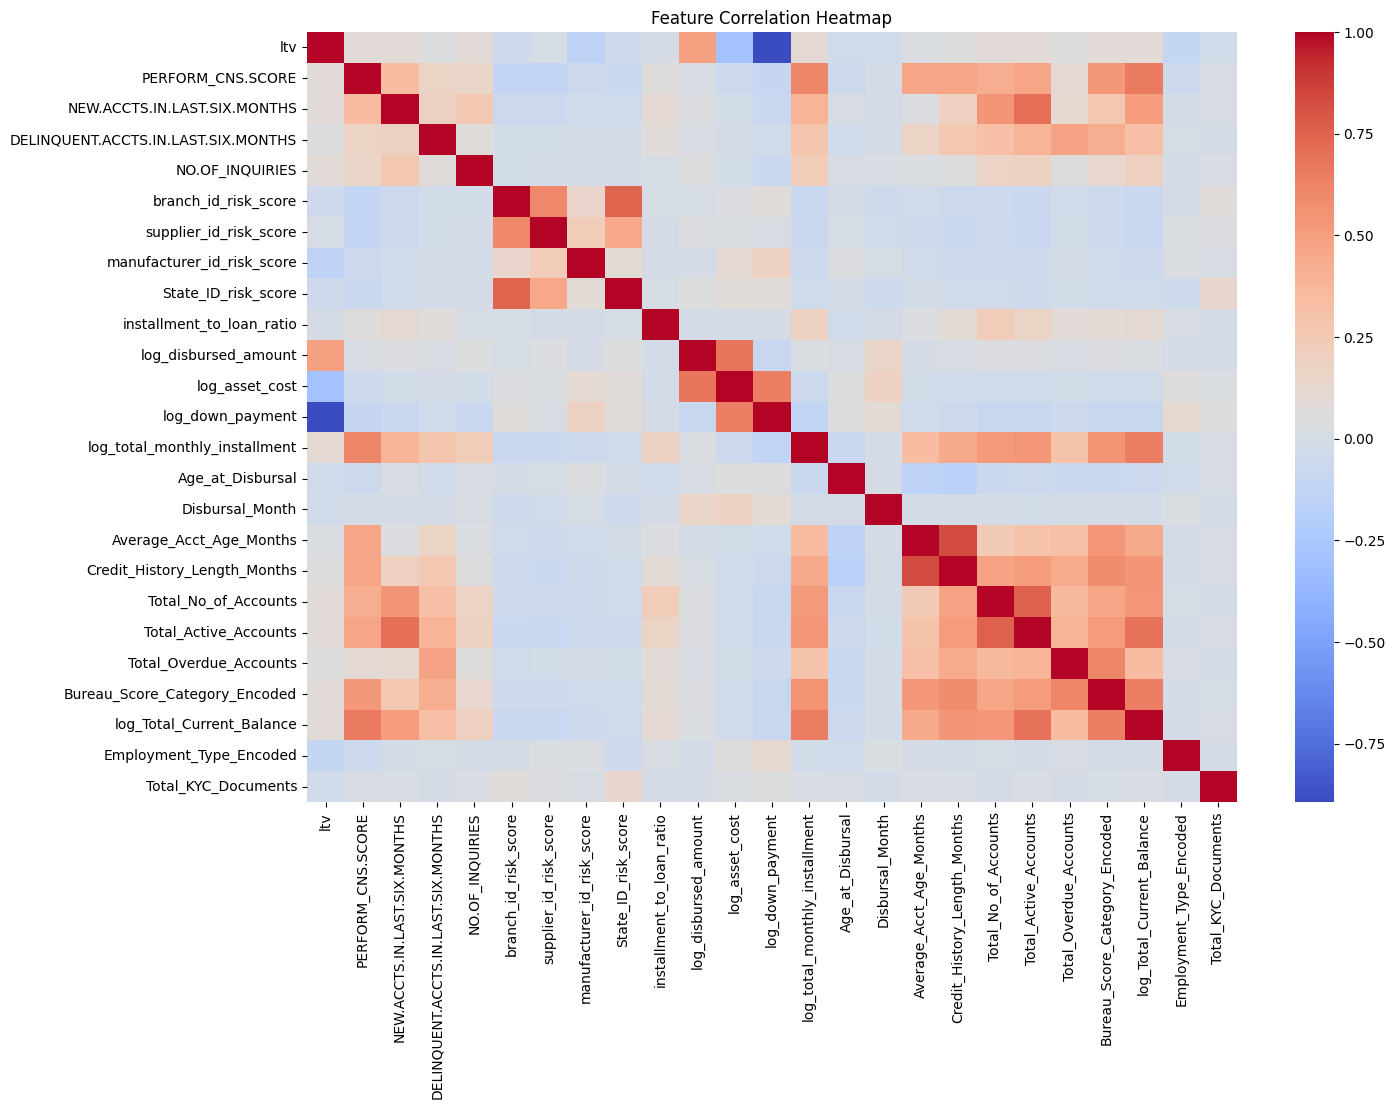

                                feature           VIF
10                 log_disbursed_amount  66568.959345
11                       log_asset_cost  55714.587861
12                     log_down_payment   8390.619222
0                                   ltv   1498.625763
7            manufacturer_id_risk_score    155.043440
15                      Disbursal_Month    126.906468
8                   State_ID_risk_score     95.197688
5                  branch_id_risk_score     66.677430
6                supplier_id_risk_score     18.779662
24                  Total_KYC_Documents     15.912874
17         Credit_History_Length_Months      6.519310
19                Total_Active_Accounts      6.064597
16              Average_Acct_Age_Months      5.685735
22            log_Total_Current_Balance      5.198225
21        Bureau_Score_Category_Encoded      4.348296
1                     PERFORM_CNS.SCORE      4.225391
18                 Total_No_of_Accounts      3.333052
13        log_total_monthly_

In [20]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

def check_multicollinearity(df):
    # 1. Select only numerical columns (VIF doesn't work on strings/categories)
    # We drop the target variable 'loan_default' because we only care about feature relationships
    X = df.drop(columns=['loan_default'], errors='ignore')
    
    # 2. Calculate Correlation Matrix first for a quick visual
    plt.figure(figsize=(15, 10))
    sns.heatmap(X.corr(), annot=False, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()

    # 3. Calculate Variance Inflation Factor (VIF)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    
    # Calculating VIF for each feature
    # Note: We add a constant for the intercept calculation
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    
    return vif_data.sort_values(by="VIF", ascending=False)

# Execute the check
vif_results = check_multicollinearity(df)
print(vif_results)

In [21]:
# List of features to drop based on VIF results
cols_to_drop_vif = [
    'log_disbursed_amount', 
    'log_asset_cost', 
    'log_down_payment',
    'manufacturer_id_risk_score' # High overlap with other risk scores
]

df_reduced = df.drop(columns=cols_to_drop_vif)

print(f"Features reduced from {len(df.columns)} to {len(df_reduced.columns)}")

Features reduced from 26 to 22


In [22]:
def calculate_vif(X_df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_df.columns
    # Calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(len(X_df.columns))]
    return vif_data.sort_values(by="VIF", ascending=False)

# We drop the target variable for the check
vif_results_reduced = calculate_vif(df_final.drop(columns=['loan_default'], errors='ignore'))

print("--- New VIF Results (Reduced Dataset) ---")
print(vif_results_reduced)

NameError: name 'df_final' is not defined

In [ ]:
# Final pruning to hit the VIF < 10 goal
final_drop = [
    'State_ID_risk_score', # Keep Branch instead
    'Disbursal_Month',     # Keep for now, or drop if it's redundant
    'Total_KYC_Documents'  # Often overlaps with borrower profile
]

df_final = df_reduced.drop(columns=final_drop, errors='ignore')

In [ ]:
# 1. Finalize the feature set based on your last VIF output
# The features in your last message are the ones we keep
final_features = [
    'branch_id_risk_score', 'supplier_id_risk_score', 'ltv', 
    'Credit_History_Length_Months', 'Total_Active_Accounts', 
    'Average_Acct_Age_Months', 'log_Total_Current_Balance', 
    'Bureau_Score_Category_Encoded', 'PERFORM_CNS.SCORE', 
    'Total_No_of_Accounts', 'log_total_monthly_installment', 
    'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'Total_Overdue_Accounts', 
    'Employment_Type_Encoded', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 
    'NO.OF_INQUIRIES', 'Age_at_Disbursal', 'installment_to_loan_ratio'
]

X_final = df[final_features]
y_final = df['loan_default']

# 2. Train-Test Split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

# 3. Train the Final Model
# Using the best parameters we found earlier
final_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=3.6, # Handling the imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

final_model.fit(X_train_f, y_train_f)

# 4. Final Evaluation
y_prob_f = final_model.predict_proba(X_test_f)[:, 1]
print(f"Final Model ROC-AUC: {roc_auc_score(y_test_f, y_prob_f):.4f}")